# Heart Attack Analysis and Prediction Dataset

# Imports

In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV

# Model Processing
from sklearn.dummy import DummyClassifier
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler


from keras.optimizers import SGD, Adam, RMSprop
from keras.regularizers import l2, l1
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Functions

In [78]:
def check_class_imbalance(df:pd.DataFrame, target:pd.Series, col:str):
  counter = Counter(target)
  for k,v in counter.items():
    per = v/len(target) * 100
    print("Class=%s, Count=%d, Percentage=%.3f%%" % (k,v, per))
    
def evaluate_model(X, y, model):
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
  
  metric = make_scorer(f1_score)
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores


def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    model_performance = []
    for i in range(len(models)):
        model = models[i]
        pipeline = Pipeline(steps=[('scaler', StandardScaler()), ("power_tranformer",PowerTransformer()), ('model', model)])
        scores = evaluate_model(X, y, pipeline)
        model_performance.append({
            "Model": names[i],
            "Mean": np.mean(scores),
            "STD":np.std(scores)
        })
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Mean", ascending=False)
def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "LDA": LinearDiscriminantAnalysis(),
    "GPC": GaussianProcessClassifier(),
    "GNB": GaussianNB(),
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "MN": MultinomialNB()
  }
  
  return [models[model] for model in names]

def test_train_test_val_splits_on_models(names, models, X, y):
    model_performance = []
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)
    
    for i in range(len(models)):
        model, model_name = models[i], names[i]
        pipeline = Pipeline(steps=[('scaler', StandardScaler()), ("power_tranformer",PowerTransformer()), ('model', model)])
        pipeline.fit(X_train, y_train)
        
        y_val_pred = pipeline.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        
        y_test_pred = pipeline.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        
        model_performance.append({
            "Model": model_name,
            "Validation Accuracy": val_accuracy,
            "Test Accuracy": test_accuracy
        })
        
        conf_mat = confusion_matrix(y_test,y_test_pred)
        plt.figure(figsize=(8,6))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix {model_name}')
        plt.show()
        
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Validation Accuracy", ascending=False)

def svm_tune_grid_search(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('power_transformer', PowerTransformer()),
        ('model', SVC())
    ])
    
    param_grid = {
        'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'model__C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    }
    
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))
    
    y_pred = grid_search.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Test accuracy: {accuracy:.3f}')
    
    return grid_search

def logistic_regression_tune_cv(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('power_transformer', PowerTransformer()),
        ('model', LogisticRegression(class_weight='balanced', penalty='l2', max_iter=2000))
    ])
    param_grid = {
        'model__solver': ['newton-cg', 'sag', 'saga', 'lbfgs'],
        'model__C': [0.1, 0.2, 0.4, 0.5, 1, 2, 4, 5, 10, 20, 50, 100, 400]
    }
    metric = make_scorer(f1_score)
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=metric, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))
    
    y_pred = grid_search.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Test accuracy: {accuracy:.3f}')
    
def grid_search_selected_models(param_grid:dict,names:list, models:list, X:pd.DataFrame, y:pd.Series, metric):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    model_performance = []

    for i in range(len(models)):
        model, name = models[i], names[i]
        pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('power_transformer', PowerTransformer()),
        ('model', model)
    ])
        grid_search = GridSearchCV(pipeline, param_grid[name], cv=5, scoring=metric, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
            
        y_pred = best_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
            
        print(f'Best score for {name}: {grid_search.best_score_:.3f}')
        print("Best parameters:", grid_search.best_params_)
        
        print(f'Test accuracy for {name}: {accuracy:.3f}')
        print("---------------------------------------------------------------")
        
        conf_mat = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8,6))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix for {names[i]}')
        plt.show()
            
        model_performance.append({
                "Model": name,
                "Best CV Score": grid_search.best_score_,
                "Test Accuracy": accuracy,
                "Best Parameters": grid_search.best_params_
        })


    model_performance_df = pd.DataFrame(model_performance)
    print(model_performance_df)


# EDA Analysis

In [64]:
df = pd.read_csv("/Users/maukanmir/Downloads/heart.csv", nrows=20000)
df

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


## Check for Nulls and Dupes

In [65]:
print(f"Null Count: {df.isna().sum()}")
print(f"Dupe Count: {df.duplicated().sum()}")

Null Count: age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64
Dupe Count: 1


## Check For Class Imbalance

In [66]:
check_class_imbalance(df,df['output'],'output')

Class=1, Count=165, Percentage=54.455%
Class=0, Count=138, Percentage=45.545%


# Dataset appears to be fairly balanced

In [67]:
df.drop_duplicates(inplace=True)

In [68]:
df.dtypes

age           int64
sex           int64
cp            int64
trtbps        int64
chol          int64
fbs           int64
restecg       int64
thalachh      int64
exng          int64
oldpeak     float64
slp           int64
caa           int64
thall         int64
output        int64
dtype: object

In [69]:
df.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,302.00000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,54.42053,0.682119,0.963576,131.602649,246.500000,0.149007,0.526490,149.569536,0.327815,1.043046,1.397351,0.718543,2.314570,0.543046
std,9.04797,0.466426,1.032044,17.563394,51.753489,0.356686,0.526027,22.903527,0.470196,1.161452,0.616274,1.006748,0.613026,0.498970
min,29.00000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.00000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.250000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.50000,1.000000,1.000000,130.000000,240.500000,0.000000,1.000000,152.500000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.00000,1.000000,2.000000,140.000000,274.750000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.00000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


# Visuals

<AxesSubplot:>

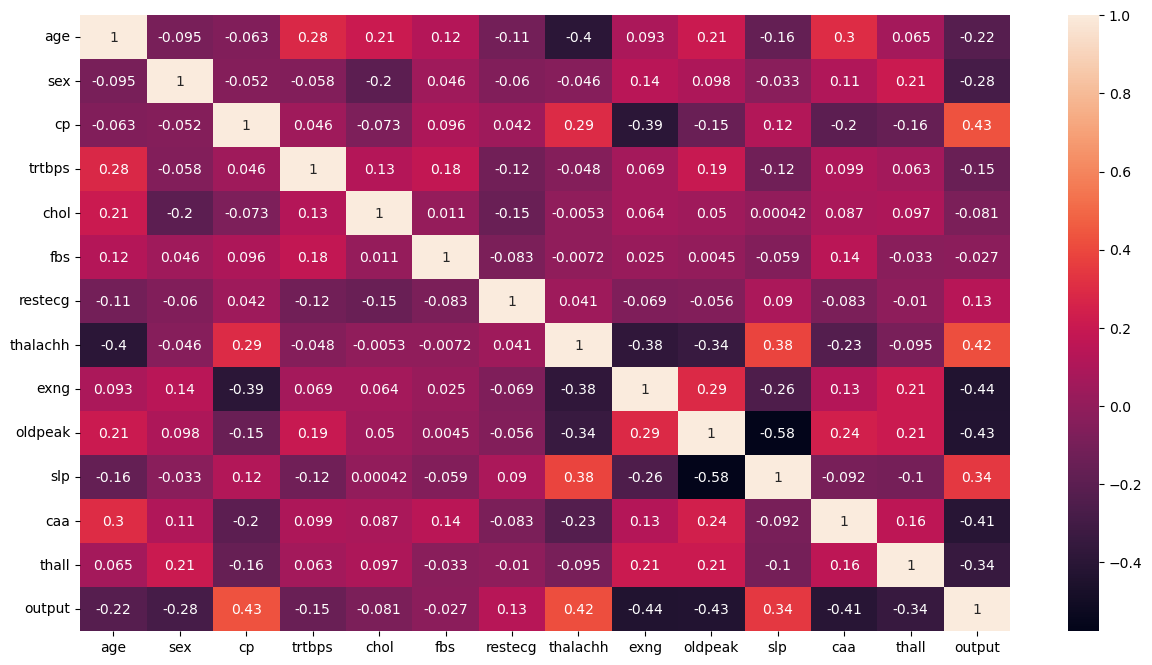

In [70]:
plt.figure(figsize=(15,8))
sns.heatmap(data=df.corr(), annot=True)

# Separate Features

In [71]:
X,y = df.drop("output",axis=1), df["output"]

# Baseline Model Evaluation

In [72]:
model = DummyClassifier(strategy="uniform")
scores = evaluate_model(X,y, model)
print('>%.3f (%.3f)' % (np.mean(scores), np.std(scores)))

>0.516 (0.065)


# Advanced Model Metrics

In [73]:
names = ['LR', 'SVC', "LDA", "GNB", "GPC", "KNN"]
models = get_selected_models(names)

testing_selected_models(names, models, X, y)

,Model,Mean,STD
2,LDA,0.874388,0.037550
0,LR,0.862090,0.038534
1,SVC,0.841619,0.029775
3,GNB,0.837121,0.031759
5,KNN,0.835746,0.036342
4,GPC,0.810586,0.035492


In [74]:
names = ['GBC', 'RFC', "DTC", "XGB"]
models = get_selected_models(names)

testing_selected_models(names, models, X, y)

,Model,Mean,STD
1,RFC,0.825938,0.030721
3,XGB,0.808816,0.042385
0,GBC,0.806396,0.037778
2,DTC,0.770905,0.056528


# MLP Tuning

In [89]:
def create_keras_classifier(function, optimizer, idx, param, validation_data):
    if idx == 0 or idx ==3:
        
        model = KerasClassifier(
            build_fn=lambda: function(input_dim=X_train.shape[1], optimizer=optimizer)
            , epochs=200, 
            batch_size=32, 
            verbose=0,
            validation_data= validation_data
            )
    elif idx ==1:
        model = KerasClassifier(
            build_fn=lambda: function(input_dim=X_train.shape[1], optimizer=optimizer, param=param)
            , epochs=100, 
            batch_size=64, 
            verbose=0,
            validation_data= validation_data
            )
        
    else:
        model = KerasClassifier(
            build_fn=lambda: function(input_dim=X_train.shape[1], optimizer=optimizer, param=param)
            , epochs=100, 
            batch_size=64, 
            verbose=0,
            validation_data= validation_data
            )
    return model

def create_model_dropout(input_dim, optimizer='adam'):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
def create_model_regularizerl2(input_dim, optimizer="adam",param= 0.001):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu', kernel_regularizer=l2(param) ))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
def create_model_regularizerL1(input_dim, optimizer="adam",param= 0.001):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu', activity_regularizer=l1(param) ))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
def create_model_without_reg(input_dim, optimizer='adam'):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

functions = [
  create_model_dropout,
  create_model_regularizerL1,
  create_model_regularizerl2,
  create_model_without_reg
]

optimizers = [
    Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07),
    SGD(lr=0.01, momentum=0.9), 
    SGD(lr=0.001, momentum=0.9),
    ]
optimizer_names = ['Adam', "RmsProp", "SGD:0.01", "SGD:0.001"]
function_names = ["Dropout", "L1", "L2", 'Without_Reg']
values = [1e-1, 1e-2, 1e-3, 1e-4]
model_performance = []
for index, function in enumerate(functions):
    name = function_names[index]
    for idx, optimizer in enumerate(optimizers):
        optimizer_name = optimizer_names[idx]
        value = values[idx]
        model = create_keras_classifier(function, optimizer, index, value, (X_val, y_val))
        
        model.fit(X_train, y_train)
        accuracy = model.score(X_test, y_test)
        model_performance.append({
            "Model": name,
            "Accuracy": accuracy,
            "Optimizer": optimizer_name,
            "Value": value
        })
model_df = pd.DataFrame(model_performance)
end_result = model_df.sort_values(by="Accuracy", ascending=False)
end_result

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_34036/1208411856.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(
/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_34036/1208411856.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(


# SVM Tune

In [76]:
svm_tune_grid_search(X, y)

Best parameters: {'model__C': 0.1, 'model__kernel': 'sigmoid'}
Best cross-validation score: 0.848
Test accuracy: 0.824


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('power_transformer',
                                        PowerTransformer()),
                                       ('model', SVC())]),
             n_jobs=-1,
             param_grid={'model__C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                      0.9, 1],
                         'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy')

# LR Tune

In [77]:
logistic_regression_tune_cv(X, y)

Best parameters: {'model__C': 0.1, 'model__solver': 'newton-cg'}
Best cross-validation score: 0.867
Test accuracy: 0.813


# Tree Models

Best score for DTC: 0.852
Best parameters: {'model__criterion': 'gini', 'model__max_depth': None, 'model__min_samples_leaf': 4, 'model__min_samples_split': 10, 'model__splitter': 'random'}
Test accuracy for DTC: 0.736
---------------------------------------------------------------


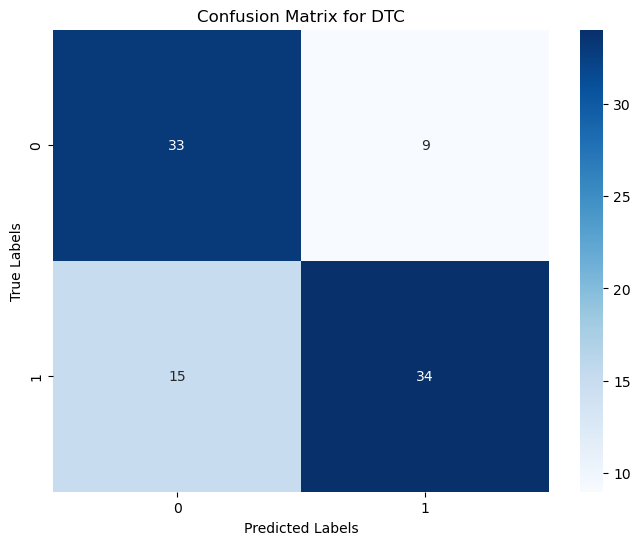

Best score for RFC: 0.858
Best parameters: {'model__max_depth': 30, 'model__min_samples_leaf': 4, 'model__min_samples_split': 10, 'model__n_estimators': 200}
Test accuracy for RFC: 0.879
---------------------------------------------------------------


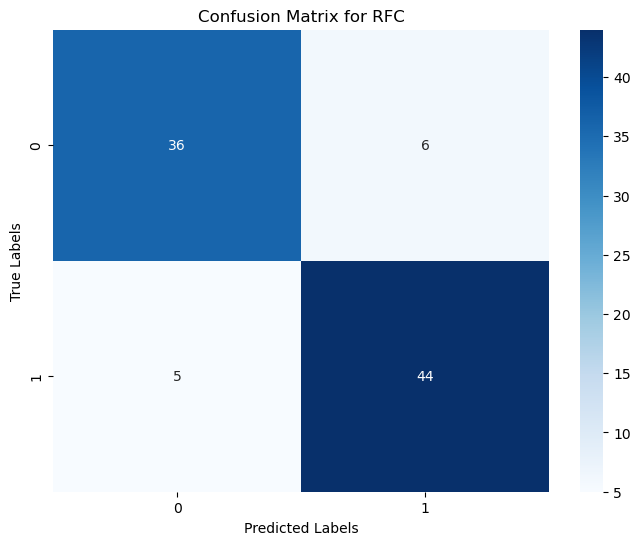

Best score for GBC: 0.830
Best parameters: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 100}
Test accuracy for GBC: 0.835
---------------------------------------------------------------


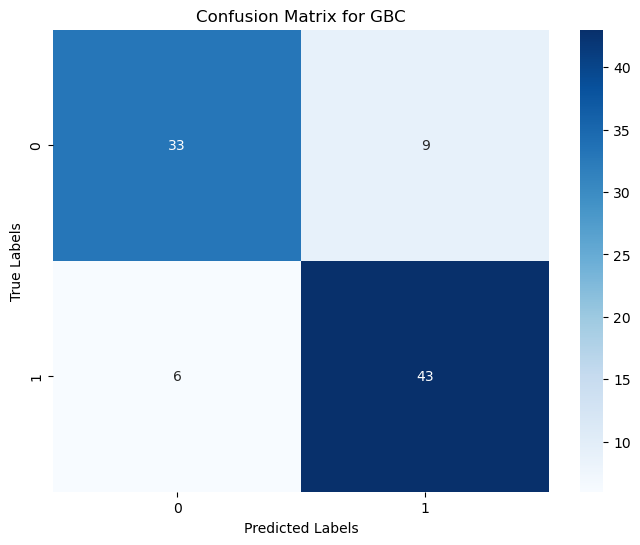

Best score for XGB: 0.851
Best parameters: {'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__n_estimators': 100}
Test accuracy for XGB: 0.813
---------------------------------------------------------------


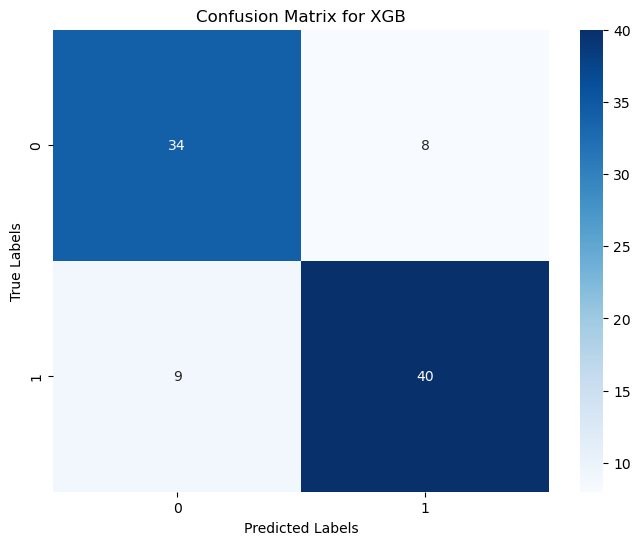

  Model  Best CV Score  Test Accuracy  \
0   DTC       0.851553       0.736264   
1   RFC       0.858050       0.879121   
2   GBC       0.830220       0.835165   
3   XGB       0.851065       0.813187   

                                     Best Parameters  
0  {'model__criterion': 'gini', 'model__max_depth...  
1  {'model__max_depth': 30, 'model__min_samples_l...  
2  {'model__learning_rate': 0.01, 'model__max_dep...  
3  {'model__learning_rate': 0.2, 'model__max_dept...  


In [84]:
names = ["DTC", "RFC", "GBC", "XGB"]
models = get_selected_models(names)

param_grid = {
    'DTC': {
        'model__criterion': ['gini', 'entropy'],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__splitter': ['best', 'random'] 
    },
    'RFC': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
    },
    'GBC': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    },
    'XGB': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [3, 5, 7],
        'model__learning_rate': [0.01, 0.1, 0.2]
    }
}

metric = make_scorer(f1_score)
grid_search_selected_models(param_grid, names, models, X, y, metric)

# The training model accuracy is performing at a lower accuracy than test accuracy. This could be because of a small dataset.